# import some necessary libraries 

In [4]:
from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval
from evaluation import Evaluation, Evaluation_metrics
from util import build_word_index, plot_one, plot_pair, hypothesis_test,TF_IDF


from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score

# For additional corpus
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader import wordnet

# For hypothesis testing
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from sys import version_info
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

import warnings
warnings.filterwarnings("ignore")

### Import Data

In [5]:
# Read queries
queries_json = json.load(open( "cranfield/cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# Read documents(corpus)
docs_json = json.load(open("cranfield/cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]

# Loading preprocessed queries from the warm up section
Preprocessed_queries = json.load(open('output/stopword_removed_queries.txt', 'r'))

# Loading Preprocessed docs from the warm up section
Preprocessed_docs = json.load(open('output/stopword_removed_docs.txt', 'r'))

qrels = json.load(open( "cranfield/cran_qrels.json", 'r'))[:]

### 1. Vector space modeling (VSM-1)

### 1. Building word map and TFIDF Representation

In [6]:
# This word_map contains word mapping to an integer. So we can identify each word with respect to its index(value)
word_map = build_word_index(Preprocessed_docs, doc_ids)

# TFIDF representation of the documents
tf_idf_docs_vsm1 = TF_IDF(Preprocessed_docs, doc_ids, word_map, normalize = True)

# TFIDF representation of queries
vec_rep_queries_vsm1 = TF_IDF(Preprocessed_queries, query_ids, word_map, normalize = True, is_queries= True)

### 2 Ranking and Evaluation

In [7]:
# Cosine similarity between the each queries with each documents
cosine_sim_vsm1 = np.matmul(tf_idf_docs_vsm1.T, vec_rep_queries_vsm1)

# Ranking based on the cosine similarity
doc_IDs_ordered_vsm1 = (np.argsort(cosine_sim_vsm1,axis=0)+1)[::-1].T.tolist()

Precision, Recall and F-score @ 1 : 0.6355555555555555, 0.10740858895443069, 0.17647363438075508
MAP, nDCG @ 1 : 0.6355555555555555, [0.47555556]
Precision, Recall and F-score @ 2 : 0.5377777777777778, 0.17305883909415462, 0.24553237456998386
MAP, nDCG @ 2 : 0.7, [0.37420598]
Precision, Recall and F-score @ 3 : 0.46666666666666673, 0.21823403948248274, 0.27595215460369193
MAP, nDCG @ 3 : 0.7022222222222222, [0.35711012]
Precision, Recall and F-score @ 4 : 0.4111111111111111, 0.25129251396781016, 0.28830129039739827
MAP, nDCG @ 4 : 0.6932098765432098, [0.35308029]
Precision, Recall and F-score @ 5 : 0.37155555555555597, 0.27732138814374324, 0.29316024707259053
MAP, nDCG @ 5 : 0.6867222222222225, [0.35165883]
Precision, Recall and F-score @ 6 : 0.34296296296296286, 0.30161193093428623, 0.29643128819289594
MAP, nDCG @ 6 : 0.6765617283950618, [0.35591917]
Precision, Recall and F-score @ 7 : 0.32000000000000034, 0.3258932761810811, 0.29802743262965026
MAP, nDCG @ 7 : 0.6635400352733684, [0.

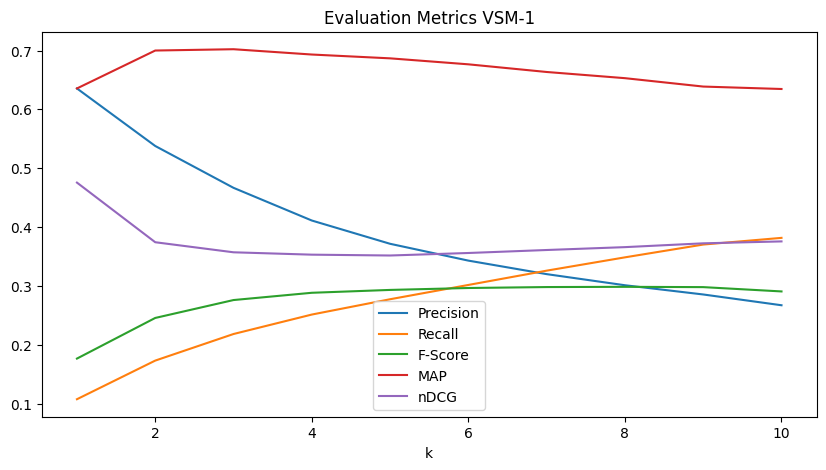

In [8]:
Evaluation_metrics(doc_IDs_ordered_vsm1, query_ids, qrels,n_comp = 0,save_results=1, title_name="Evaluation Metrics VSM-1")

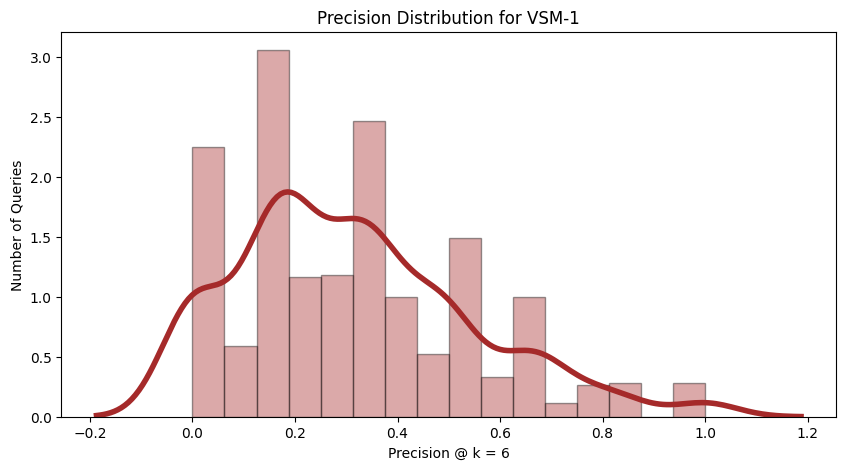

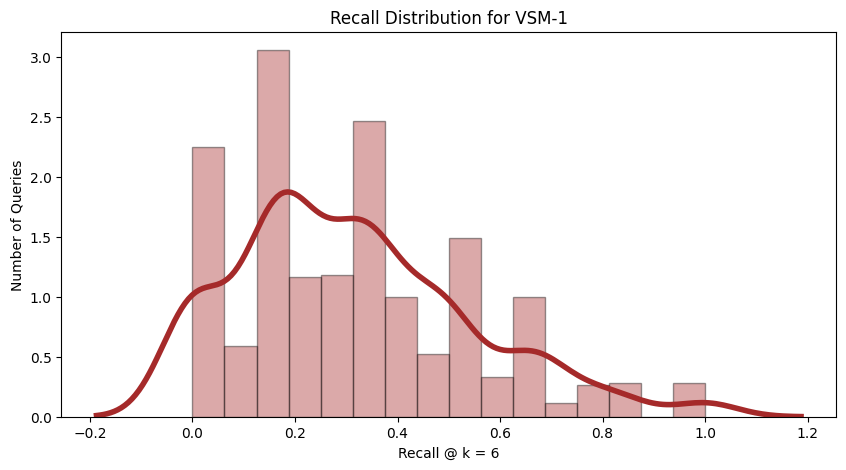

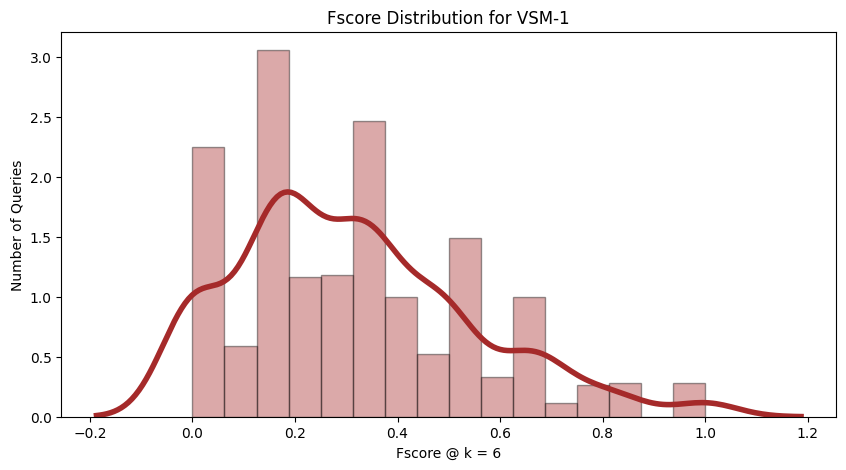

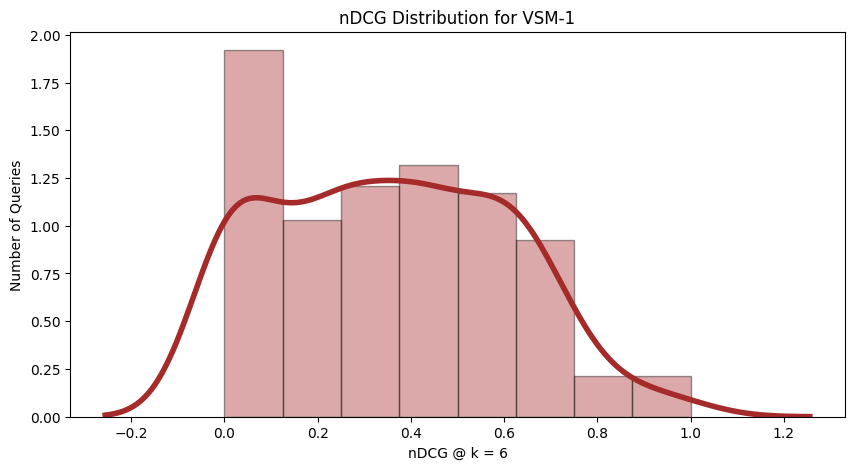

In [9]:
q_precision_vsm1, q_recall_vsm1, q_fscore_vsm1, q_ndcg_vsm1 = plot_one(qrels, doc_IDs_ordered_vsm1,queries,
                                                                      k = 6, model_name = 'VSM-1')

## 2. Vector space modeling (VSM-2)
This model has additional preprocessing techniques like removing frequent words related to dataset, punctutation removing, number removals and so on... It is observed that VSM-2 model outperforms the VSM-1. So we use VSM-2 as out basemodel.

### 1 Data Preprocessing

In [10]:
import re
import string
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Replace contractions
    contraction_patterns = [(r"i'm", "i am"), (r"you'll", "you will"), (r"i'll", "i will"),
                            (r"she'll", "she will"), (r"he'll", "he will"), (r"he's", "he is"),
                            (r"she's", "she is"), (r"that's", "that is"), (r"what's", "what is"),
                            (r"where's", "where is"), (r"there's", "there is"), (r"here's", "here is"),
                            (r"who's", "who is"), (r"how's", "how is"), (r"\'ll", " will"),
                            (r"\'ve", " have"), (r"\'re", " are"), (r"\'d", " would"),
                            (r"can't", "cannot"), (r"won't", "will not"), (r"don't", "do not"),
                            (r"shouldn't", "should not"), (r"n't", " not")]
    for pattern, replacement in contraction_patterns:
        text = re.sub(pattern, replacement, text)
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z]", " ", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def remove_punctuation(text):
    # Remove punctuation
    PUNCT_TO_REMOVE = string.punctuation + '“”’_'
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    # Remove stopwords
    return " ".join([word for word in text.split() if word not in STOPWORDS])

def lemmatize_words(text):
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# Apply preprocessing to queries and docs
query_df = pd.DataFrame(queries,columns = ['query'])
docs_df = pd.DataFrame(docs_json).drop(['author','bibliography','id','title'],axis=1)
query_df['preprocessed'] = query_df['query'].apply(preprocess_text)
docs_df['preprocessed'] = docs_df['body'].apply(preprocess_text)

query_df['preprocessed'] = query_df['preprocessed'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize_words)
docs_df['preprocessed'] = docs_df['preprocessed'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize_words)

docs_df.head()

,body,preprocessed
0,experimental investigation of the aerodynamics...,experimental investigation aerodynamics wing s...
1,simple shear flow past a flat plate in an inco...,simple shear flow past flat plate incompressib...
2,the boundary layer in simple shear flow past a...,boundary layer simple shear flow past flat pla...
3,approximate solutions of the incompressible la...,approximate solution incompressible laminar bo...
4,one-dimensional transient heat conduction into...,one dimensional transient heat conduction doub...


In [11]:
# combining the documents and queries.
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()

### 2 Tfidf Representation

In [12]:
# we use sklearn tfidf vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 5604


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# documents tfidf representation 
tf_idf_docs_vsm2 = tfidf_df[columns[:len(docs_df)]].values

# queries tfidf representation
vec_rep_queries_vsm2 = tfidf_df[columns[len(docs_df):]].values

### 3 Ranking and Evaluation

In [14]:
# cosine similarity between documents and queries
cosine_sim_vsm2 = np.matmul(tf_idf_docs_vsm2.T, vec_rep_queries_vsm2)

# Documents are ordered based on cosine similarity
doc_IDs_ordered_vsm2 = (np.argsort(cosine_sim_vsm2,axis=0)+1)[::-1].T.tolist()

Precision, Recall and F-score @ 1 : 0.6933333333333334, 0.11813159596691133, 0.19345722168811094
MAP, nDCG @ 1 : 0.6933333333333334, [0.52740741]
Precision, Recall and F-score @ 2 : 0.5666666666666667, 0.18859036312567867, 0.26577595814690075
MAP, nDCG @ 2 : 0.7333333333333333, [0.41204701]
Precision, Recall and F-score @ 3 : 0.5007407407407409, 0.24088233127783326, 0.3022374292347652
MAP, nDCG @ 3 : 0.733703703703704, [0.39100624]
Precision, Recall and F-score @ 4 : 0.46111111111111114, 0.28726653227454285, 0.32769150280712667
MAP, nDCG @ 4 : 0.72320987654321, [0.39030964]
Precision, Recall and F-score @ 5 : 0.41155555555555584, 0.3132692600374572, 0.3281620307874807
MAP, nDCG @ 5 : 0.7205185185185184, [0.39033649]
Precision, Recall and F-score @ 6 : 0.37925925925925913, 0.3417134418666964, 0.3315977221122444
MAP, nDCG @ 6 : 0.7093382716049381, [0.39637713]
Precision, Recall and F-score @ 7 : 0.3561904761904765, 0.3688050070190457, 0.33406310057661737
MAP, nDCG @ 7 : 0.697589065255731

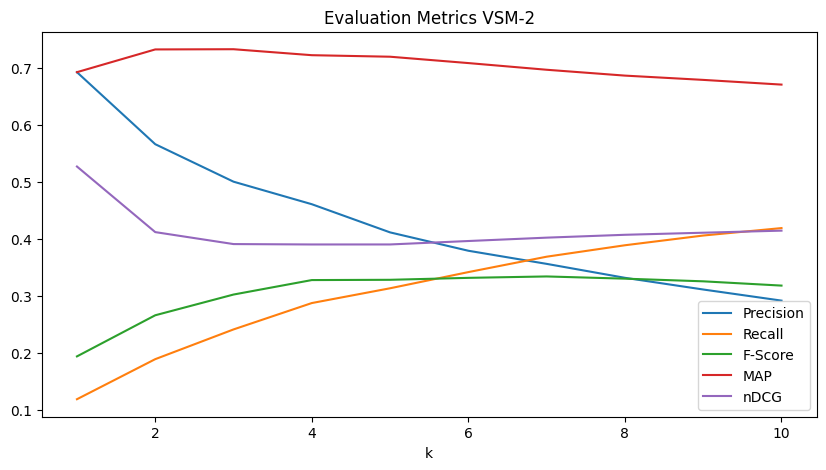

In [15]:
Evaluation_metrics(doc_IDs_ordered_vsm2, query_ids, qrels,n_comp = 0,save_results=1, title_name="Evaluation Metrics VSM-2")

### 4 Observations

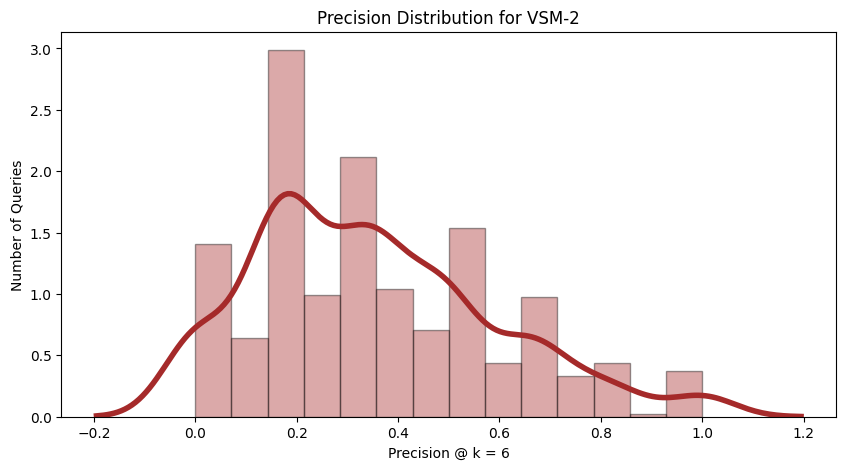

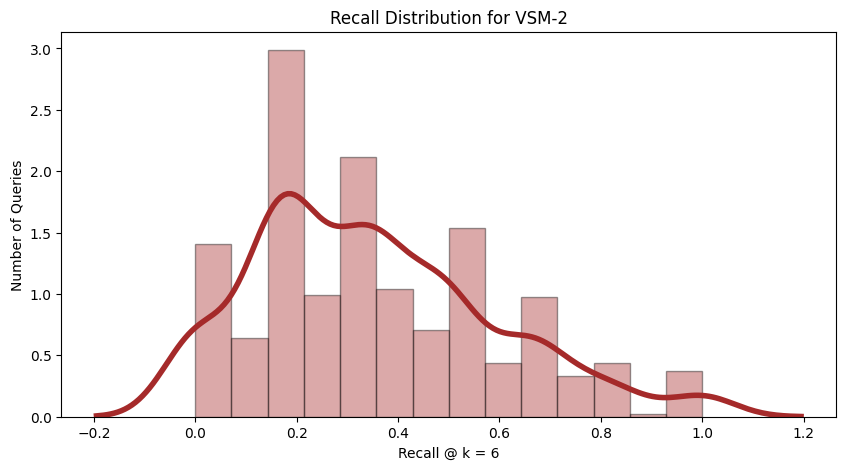

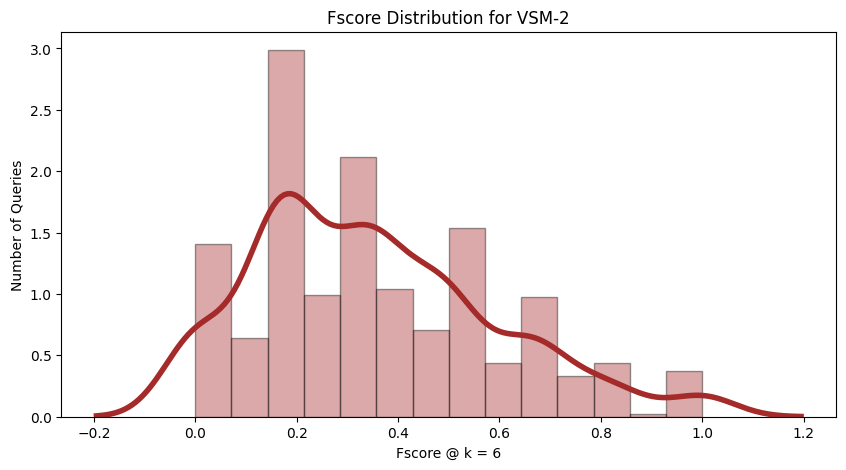

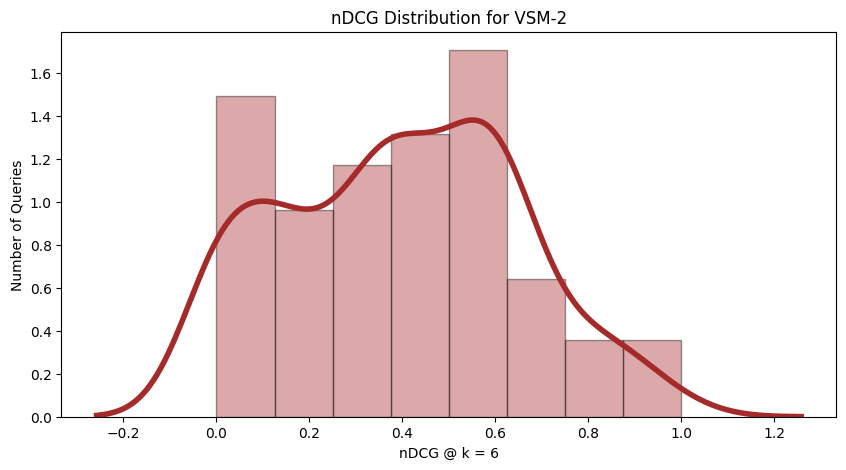

In [16]:
q_precision_vsm2, q_recall_vsm2, q_fscore_vsm2, q_ndcg_vsm2 = plot_one(qrels, doc_IDs_ordered_vsm2,
                                                                 queries, k = 6, model_name = 'VSM-2')

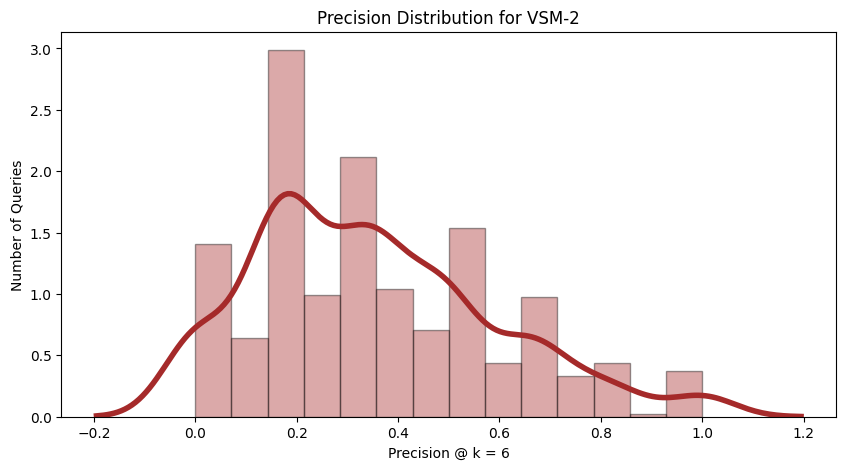

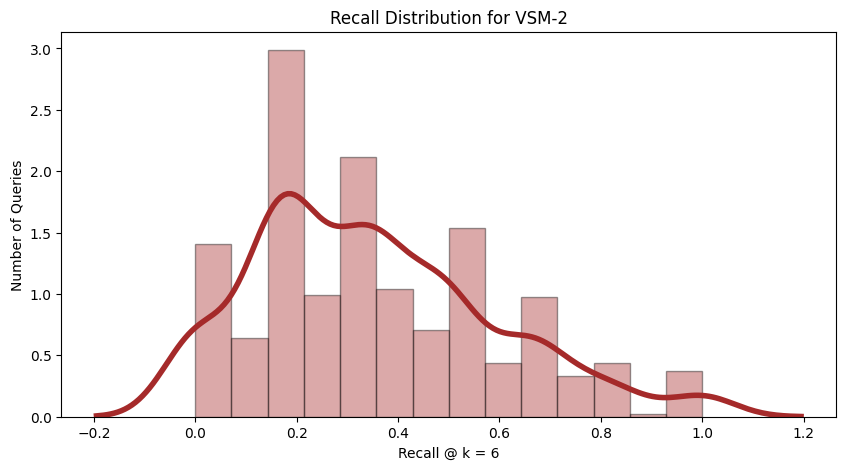

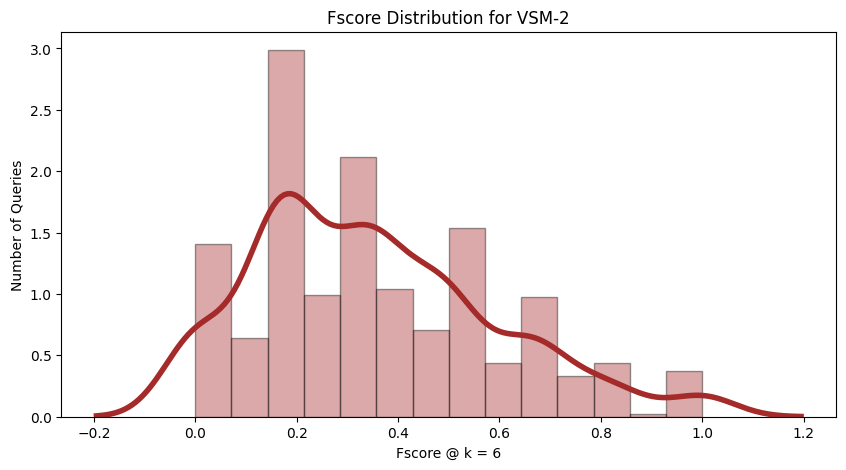

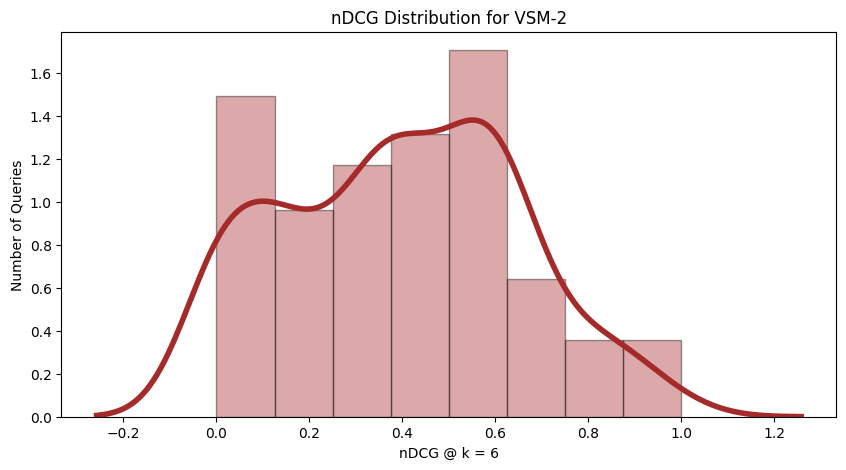

In [17]:
q_precision_vsm2, q_recall_vsm2, q_fscore_vsm2, q_ndcg_vsm2 = plot_one(qrels, doc_IDs_ordered_vsm2,
                                                                 queries, k = 6, model_name = 'VSM-2')

### 5 VSM-1 Vs VSM-2
From below, we can observe that VSM-2 model outperforms the VSM-1 model in all the metrics. You could see that VSM-2 model decreases the count of lower precision or recall or ndcg or fscore and increases the count for the higher precision or recall or ndcg or fscore queries.

From now on VSM-2 is our baseline model to be compared with other models

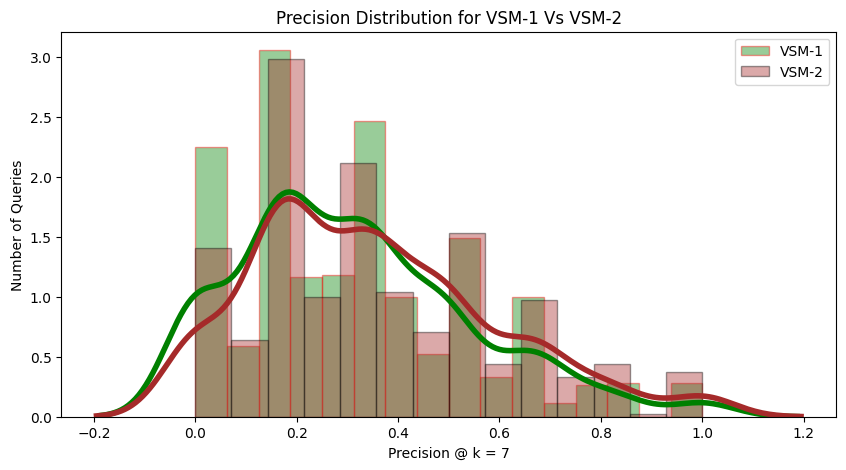

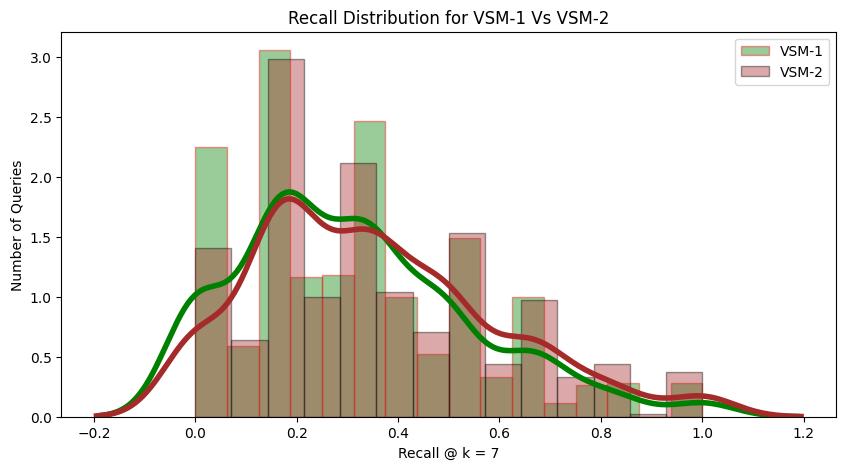

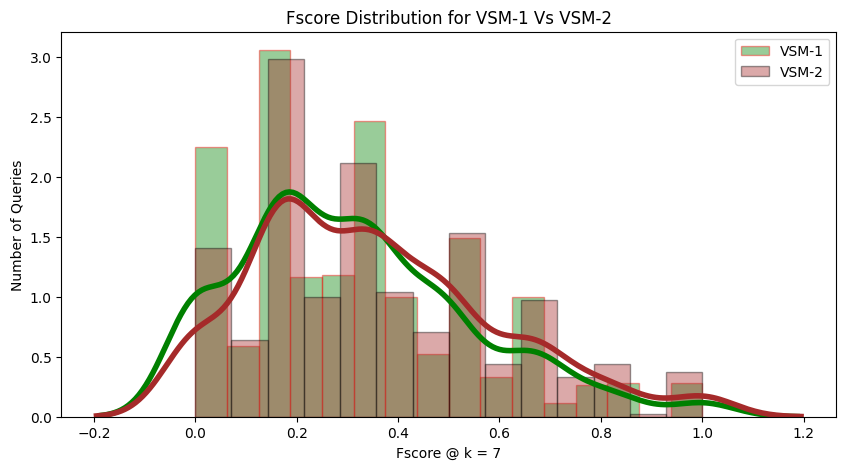

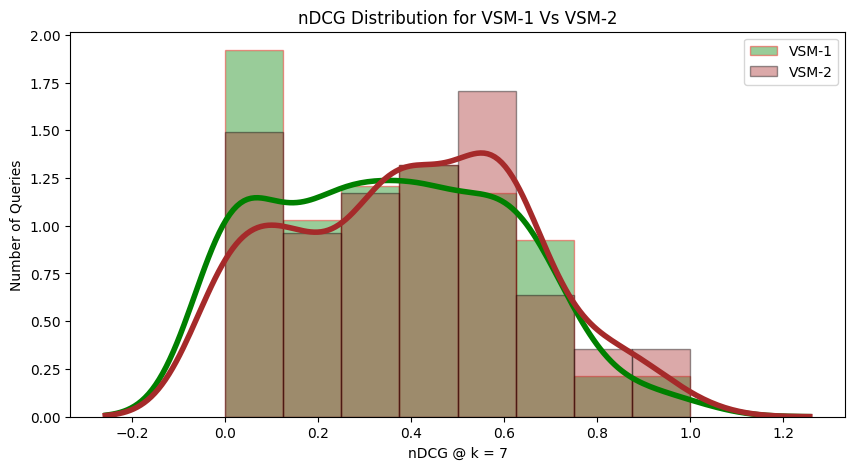

In [18]:
# from observations import run_comp
plot_pair(q_precision_vsm1, q_precision_vsm2, q_recall_vsm1, q_recall_vsm2,
         q_fscore_vsm1, q_fscore_vsm2, q_ndcg_vsm1, q_ndcg_vsm2, k = 7, model1_name = 'VSM-1', model2_name = 'VSM-2')

In [19]:
# VSM-1 Vs VSM-2 (precision)
hypothesis_test(q_precision_vsm1, q_precision_vsm2)

formula: t = -2.91671  p = 0.00359636


In [20]:
# VSM-1 Vs VSM-2 (recall)
hypothesis_test(q_recall_vsm1, q_recall_vsm2)

formula: t = -2.91671  p = 0.00359636


In [21]:
# VSM-1 Vs VSM-2 (f-score)
hypothesis_test(q_fscore_vsm1, q_fscore_vsm2)

formula: t = -2.91671  p = 0.00359636


In [22]:
# VSM-1 Vs VSM-2 (ndcg)
hypothesis_test(q_ndcg_vsm1, q_ndcg_vsm2)

formula: t = -1.69729  p = 0.0903366


## 3. Latent semantic Analysis (LSA)

### 1 TFIDF Vectorizer

In [23]:
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tf_idf_docs_lsa = tfidf_df[columns[:len(docs_df)]].values
vec_rep_queries_lsa = tfidf_df[columns[len(docs_df):]].values
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 5604


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2 Fine Tuning for n_components in LSA

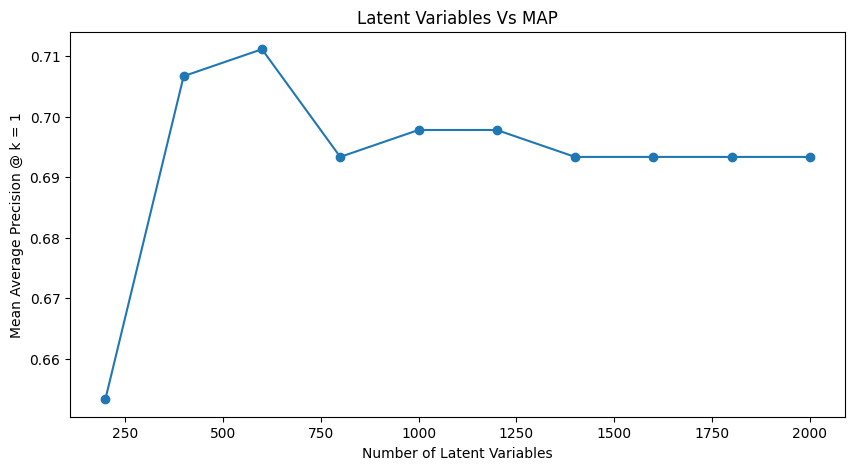

In [49]:
components_used = [200, 400, 600, 800, 1000, 1200, 1400, 1600,1800,2000]
evaluator = Evaluation()
MAP = []
for n_comp in components_used:
    # using Singular value decomposition
    svd = TruncatedSVD(n_components=n_comp)
    svd.fit(tf_idf_docs_lsa.T)
    # transformed documents
    tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
    # transformed queries
    qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
    # cosine similarity
    cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
    # documents ranking for queries using lsa
    doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
    # print("\nLSA with "+str(n_comp)+" in progress\n")
    title = "LSA with "+ str(n_comp) + " latent variables"
    Evaluation_metrics(doc_IDs_ordered_lsa, query_ids, qrels,n_comp = n_comp,save_results=0, title_name=title, verbose=0)
    # Storing all the MAP values for each n_comp
    MAP.append(evaluator.meanAveragePrecision(doc_IDs_ordered_lsa, query_ids, qrels, k =1))
plt.figure(figsize=(10,5))
plt.plot(components_used, MAP)
plt.scatter(components_used, MAP)
plt.title('Latent Variables Vs MAP')
plt.xlabel('Number of Latent Variables')
plt.ylabel('Mean Average Precision @ k = 1')
plt.show()

### 3 Final LSA with Optimal Latent Variables


LSA with 500 in progress

Precision, Recall and F-score @ 1 : 0.7066666666666667, 0.11883513933712138, 0.19466212789301715
MAP, nDCG @ 1 : 0.7066666666666667, [0.53481481]
Precision, Recall and F-score @ 2 : 0.5755555555555556, 0.18922926262009923, 0.26747385609041263
MAP, nDCG @ 2 : 0.74, [0.41436453]
Precision, Recall and F-score @ 3 : 0.5096296296296298, 0.24235598471227107, 0.30539856439590035
MAP, nDCG @ 3 : 0.7355555555555555, [0.39145142]
Precision, Recall and F-score @ 4 : 0.47333333333333333, 0.29412217305237137, 0.335590904196816
MAP, nDCG @ 4 : 0.7313580246913577, [0.39704781]
Precision, Recall and F-score @ 5 : 0.4240000000000002, 0.3231010843496736, 0.3384872222798549
MAP, nDCG @ 5 : 0.7283148148148144, [0.39671378]
Precision, Recall and F-score @ 6 : 0.388888888888889, 0.35322884802916127, 0.3413639762553102
MAP, nDCG @ 6 : 0.7153999999999996, [0.40350777]
Precision, Recall and F-score @ 7 : 0.3619047619047624, 0.3780988668991803, 0.34143448579573726
MAP, nDCG @ 7 : 0.70

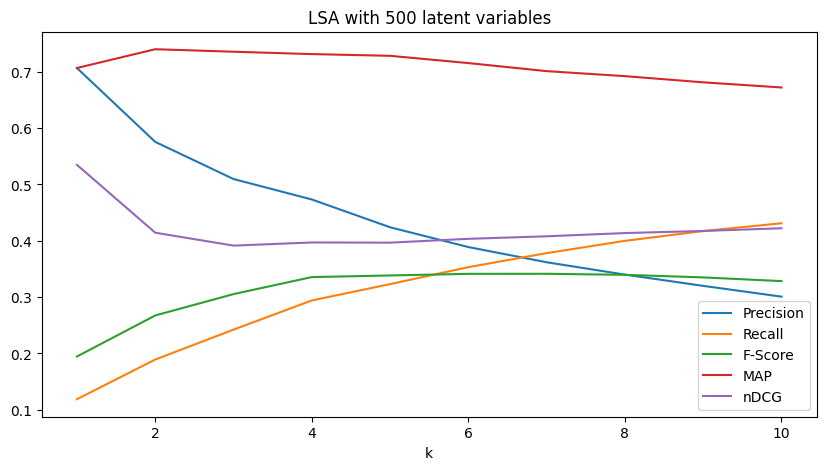

In [25]:
# best value, k = 500 latent dimensions
n_comp = 500
svd = TruncatedSVD(n_components=n_comp)
svd.fit(tf_idf_docs_lsa.T)
tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
print("\nLSA with "+str(n_comp)+" in progress\n")
title = "LSA with "+ str(n_comp) + " latent variables"
Evaluation_metrics(doc_IDs_ordered_lsa, query_ids, qrels,n_comp = n_comp,save_results=1, title_name=title)

### 4 Observations

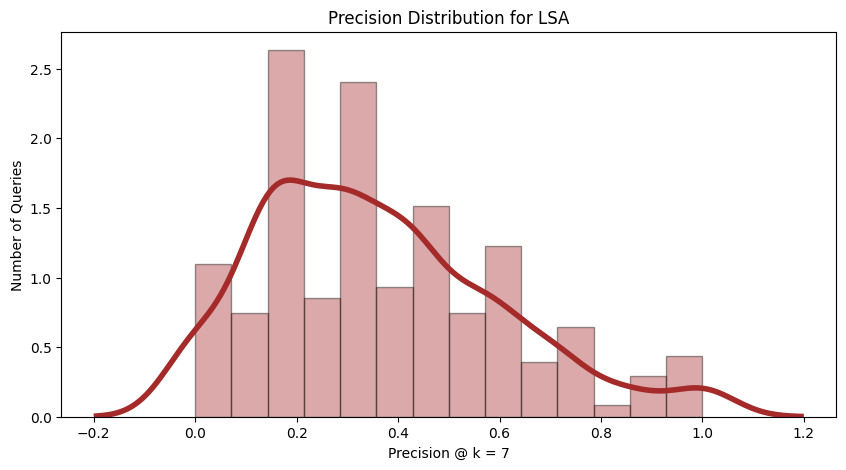

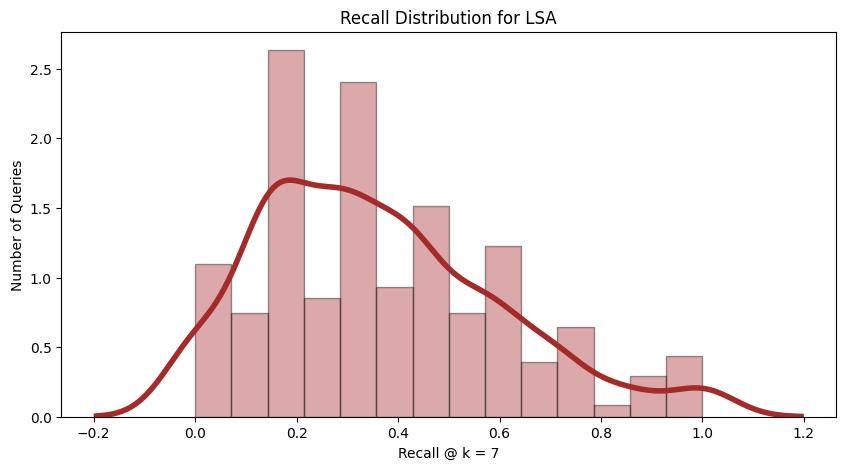

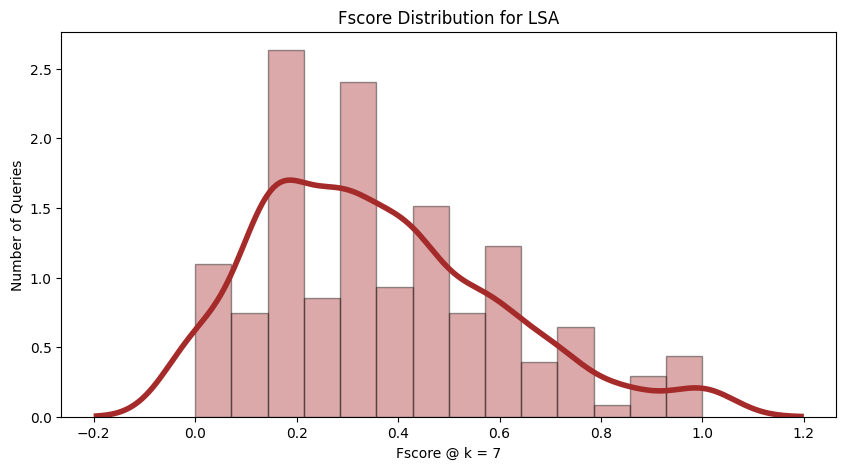

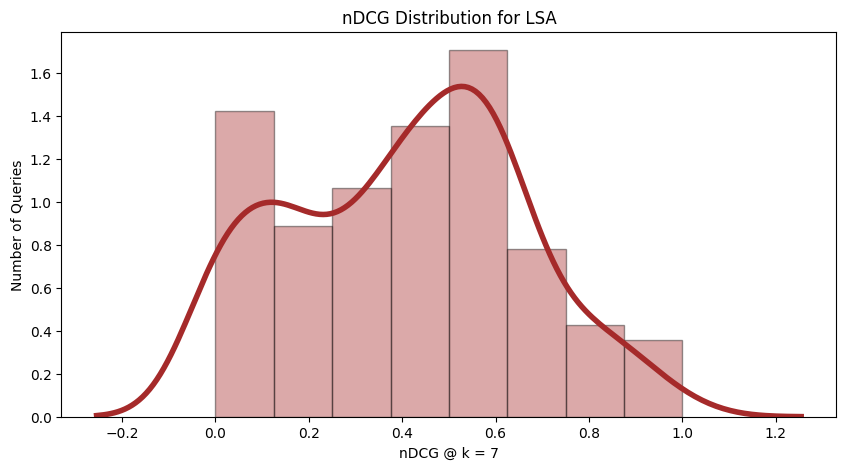

In [26]:
q_precision_lsa, q_recall_lsa, q_fscore_lsa, q_ndcg_lsa = plot_one(qrels, doc_IDs_ordered_lsa,
                                                                 queries, k = 7, model_name = 'LSA')

### 5 VSM-2 Vs LSA
Seems not much improvement in performance, but we could see that LSA performed better than the VSM-2 almost in all the instants. But clear improvement in nDCG i.e LSA improved the ranking order and performed better than the VSM-2.

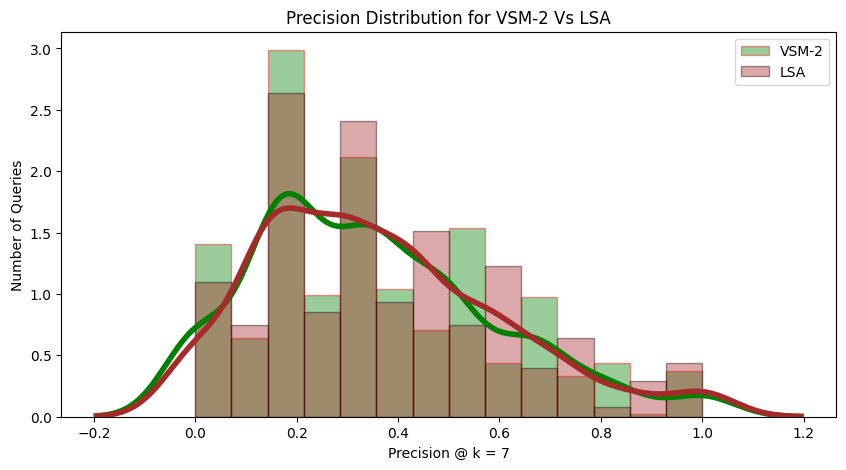

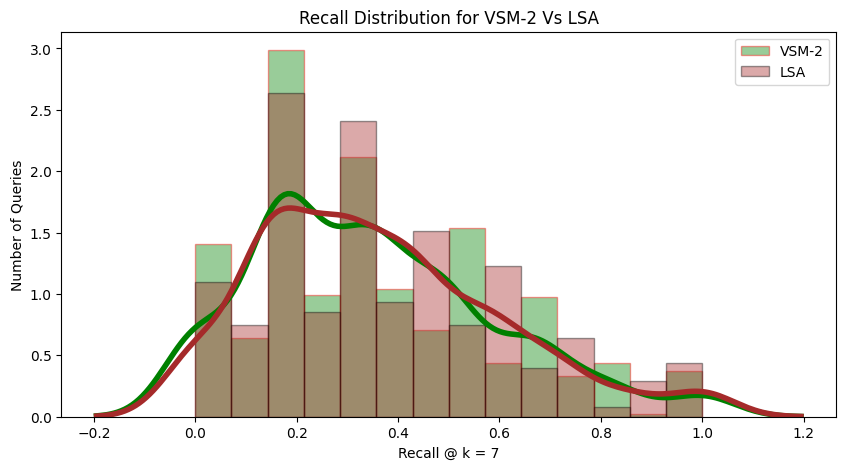

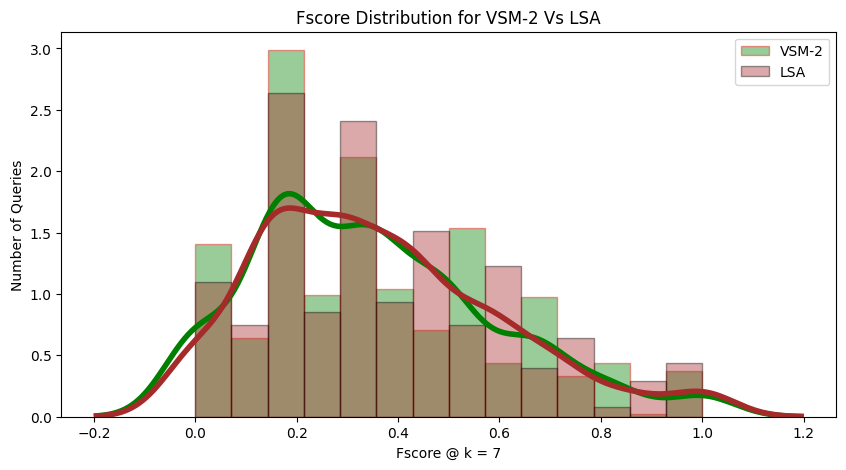

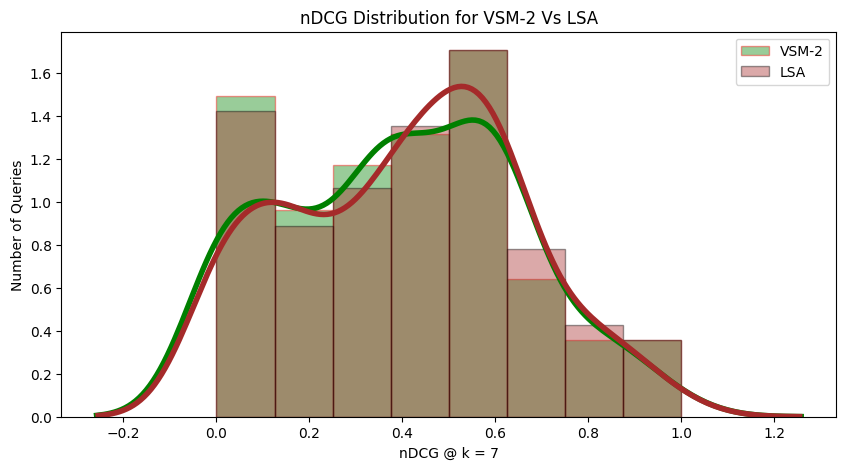

In [27]:
plot_pair(q_precision_vsm2, q_precision_lsa, q_recall_vsm2, q_recall_lsa,
         q_fscore_vsm2, q_fscore_lsa, q_ndcg_vsm2, q_ndcg_lsa, k = 7, model1_name = 'VSM-2', model2_name = 'LSA')

### 6 Two Sample t-test

***Null Hypothesis*** : VSM2 and LSA are performing same

***Alternate Hypothesis*** : VSM2 and LSA are not performing same

***Results***: p-value > 0.05, so we do not have enough evidence to reject the Null Hypothesis

In [28]:
# Hypothesis Testing VSM-2 Vs LSA
print('Precision')
hypothesis_test(q_precision_vsm2, q_precision_lsa)

print('Recall')
hypothesis_test(q_recall_vsm2, q_recall_lsa)

print('FScore')
hypothesis_test(q_fscore_vsm2, q_fscore_lsa)

print('nDCG')
hypothesis_test(q_ndcg_vsm2, q_ndcg_lsa)

Precision
formula: t = -0.740566  p = 0.459086
Recall
formula: t = -0.740566  p = 0.459086
FScore
formula: t = -0.740566  p = 0.459086
nDCG
formula: t = -0.488379  p = 0.62552


### 4. Query Expansion (QE)
We try to expand the query by adding the similar words of the query.

### 1 Distributional Word Similarity

In [29]:
# using word-2-vec pretrained word embedding
from gensim.models import Word2Vec
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
All_sentences = [sent.split(" ") for sent in corpus]

model = Word2Vec(min_count=1,
                window = 3,
                vector_size = 500,
                sample = 6e-5)
t = time.time()
model.build_vocab(All_sentences, progress_per = 1000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()

# training word embeddings on corpus
model.train(All_sentences, total_examples=model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

res = np.array(model.wv.most_similar(positive=["good"]))[:,0].tolist()[:5]
res

Time to build vocab: 0.0 mins
Time to train the model: 0.04 mins


['agreement', 'compare', 'prediction', 'agree', 'predict']

### 2 Query Expansion

In [30]:
def query_expansion(query, wv_model,v=1):
    """
    query : query to be expanded (a list of lists, where each sublist is a sentence)
    wv_model : word2vec trained model
    v : top v similar words taken into consideration
    """
    expanded_query = []
    for sent in query:
        
        for word in sent:
            
            try:
                expanded_query+=(np.array(wv_model.wv.most_similar(positive=[word],topn = v))[:,0].tolist())
            except:
                pass
    return " ".join(expanded_query)

query_df['expanded_query'] = query_df["preprocessed"].apply(lambda x: query_expansion([x.split(" ")], model))
query_df['expanded_query'] += query_df['preprocessed']
query_df.head()

,query,preprocessed,expanded_query
0,what similarity laws must be obeyed when const...,similarity law must obey construct aeroelastic...,law relation comment tensor conformal estimati...
1,what are the structural and aeroelastic proble...,structural aeroelastic problem associate fligh...,fatigue estimation author proximity fly hyperv...
2,what problems of heat conduction in composite ...,problem heat conduction composite slab solve far,author transfer dissipation slab composite par...
3,can a criterion be developed to show empirical...,criterion develop show empirically validity fl...,interpretation simple chapman reiss permit dim...
4,what chemical kinetic system is applicable to ...,chemical kinetic system applicable hypersonic ...,mixture electron must apply nosed oscillatory ...


### 3 TFIDF Representation

In [31]:
vectorizer = TfidfVectorizer()
corpus_qe = docs_df['preprocessed'].tolist() + query_df['expanded_query'].tolist()
X = vectorizer.fit_transform(corpus_qe)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 5824


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
tf_idf_docs_qe = tfidf_df[columns[:len(docs_df)]].values
vec_rep_queries_qe = tfidf_df[columns[len(docs_df):]].values
#= vectorizer.transform(query_df["expanded_query"].tolist()).T.todense()

### 4 Ranking and Evaluation

Precision, Recall and F-score @ 1 : 0.52, 0.0920126542924486, 0.15017360934051505
MAP, nDCG @ 1 : 0.52, [0.3837037]
Precision, Recall and F-score @ 2 : 0.4533333333333333, 0.1509285164881051, 0.21280447525149535
MAP, nDCG @ 2 : 0.58, [0.31649188]


Precision, Recall and F-score @ 3 : 0.39555555555555555, 0.19227108626400827, 0.2408032045181253
MAP, nDCG @ 3 : 0.5903703703703703, [0.30417677]
Precision, Recall and F-score @ 4 : 0.37444444444444447, 0.23448929949594713, 0.26725355476581997
MAP, nDCG @ 4 : 0.5912345679012346, [0.3123953]
Precision, Recall and F-score @ 5 : 0.3431111111111114, 0.26228893767071426, 0.2751314965812385
MAP, nDCG @ 5 : 0.5843765432098764, [0.31083772]
Precision, Recall and F-score @ 6 : 0.31703703703703706, 0.28747829152673476, 0.27904837263767635
MAP, nDCG @ 6 : 0.5792246913580247, [0.31636509]
Precision, Recall and F-score @ 7 : 0.290793650793651, 0.3055016373167472, 0.27575179593834054
MAP, nDCG @ 7 : 0.5737435626102293, [0.32258461]
Precision, Recall and F-score @ 8 : 0.27111111111111114, 0.3220109199730889, 0.2726771489031255
MAP, nDCG @ 8 : 0.5667738977072312, [0.3273184]
Precision, Recall and F-score @ 9 : 0.25382716049382725, 0.334986928000821, 0.26780965228747927
MAP, nDCG @ 9 : 0.56194809145880

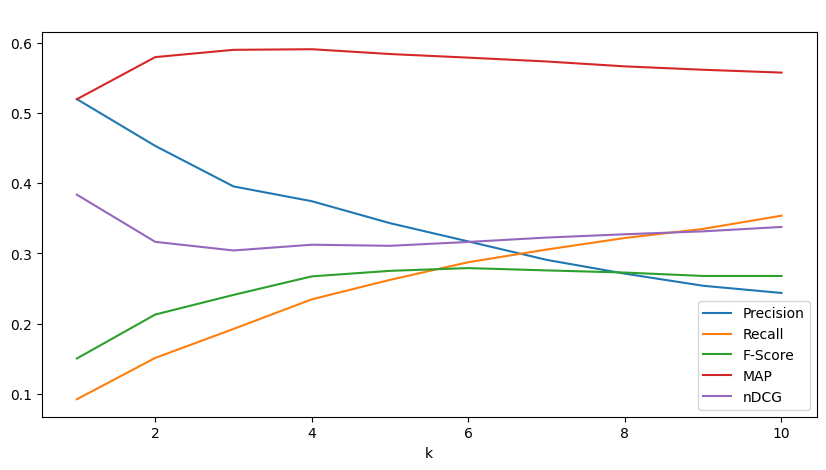

In [33]:
cosine_sim_qe = np.matmul(tf_idf_docs_qe.T, vec_rep_queries_qe)
doc_IDs_ordered_qe = (np.argsort(cosine_sim_qe,axis=0)+1)[::-1].T.tolist()
Evaluation_metrics(doc_IDs_ordered_qe, query_ids, qrels,n_comp = 0,save_results=1)

### 5 Observations

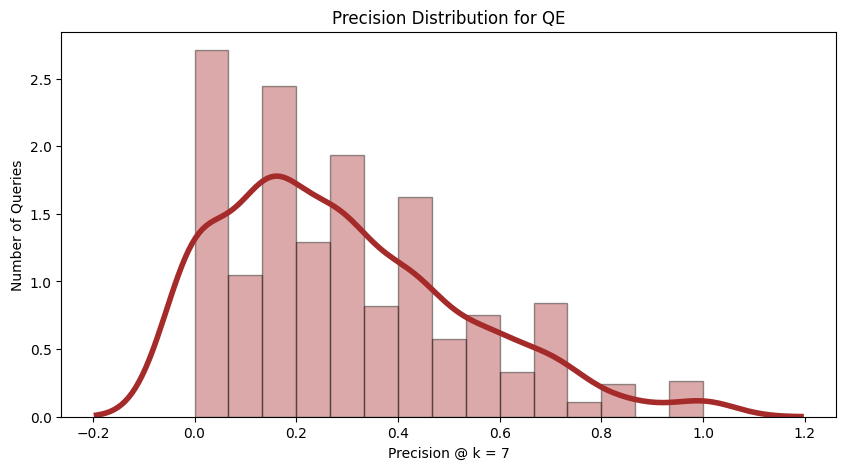

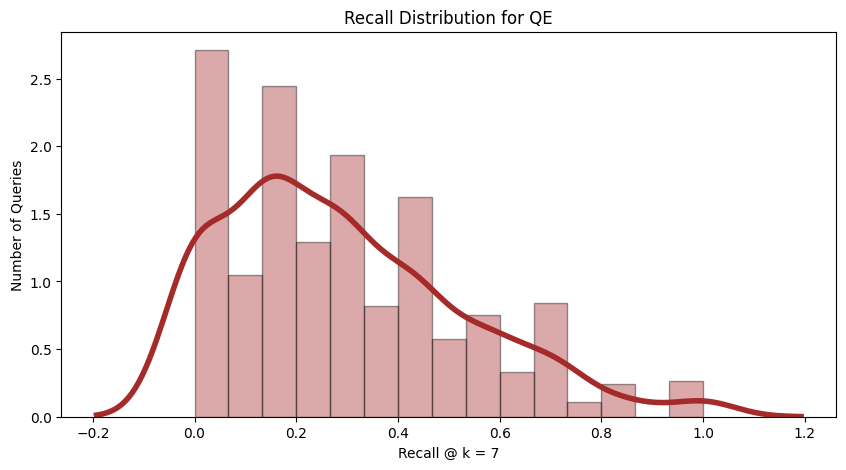

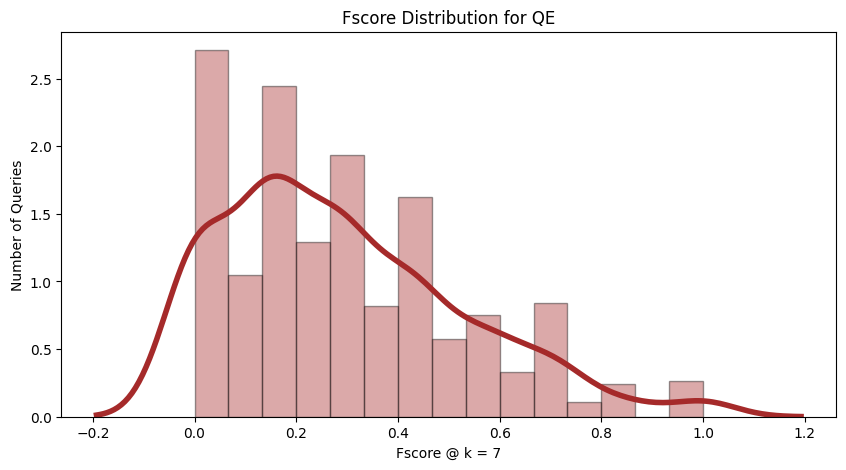

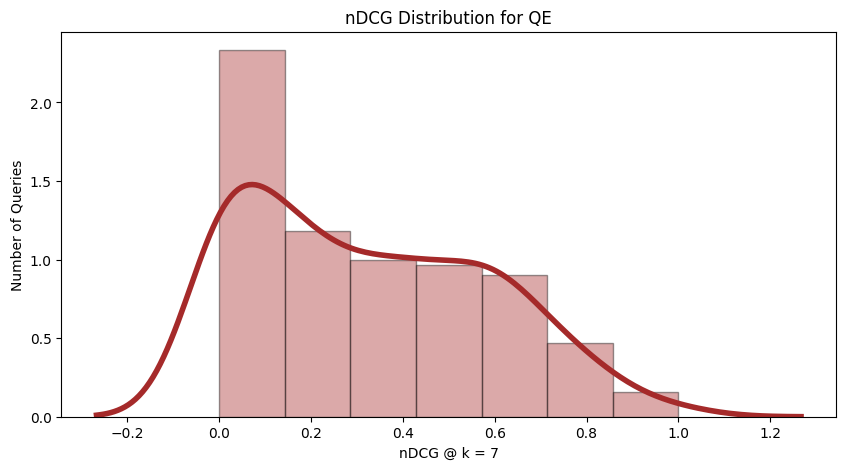

In [34]:
q_precision_qe, q_recall_qe, q_fscore_qe, q_ndcg_qe = plot_one(qrels, doc_IDs_ordered_qe,
                                                                 queries, k = 7, model_name = 'QE')

### 6 Query Expansion Vs LSA
Clearly Query expansion performs worse than our base model (VSM-2). This is to be anticipated given the limited corpus on which we trained word2vec. If we have a large enough corpus to train our word2vec model, it may boost the query expansion model's performance. In this approach, we expect the QE Model to enhance recall.

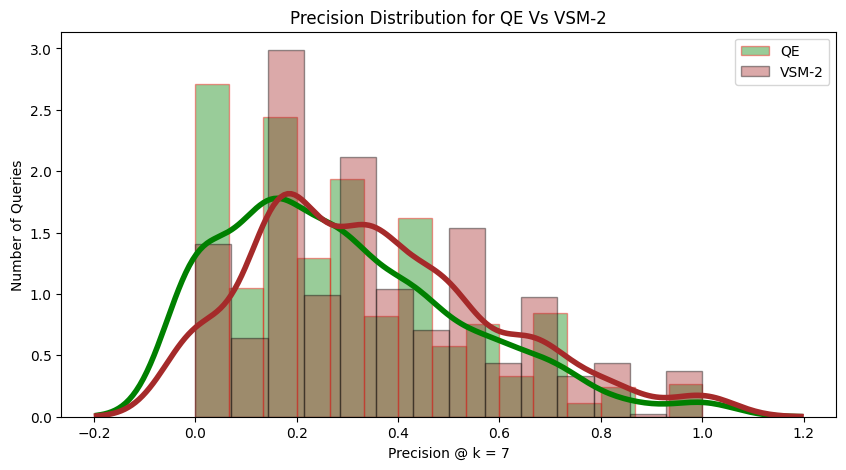

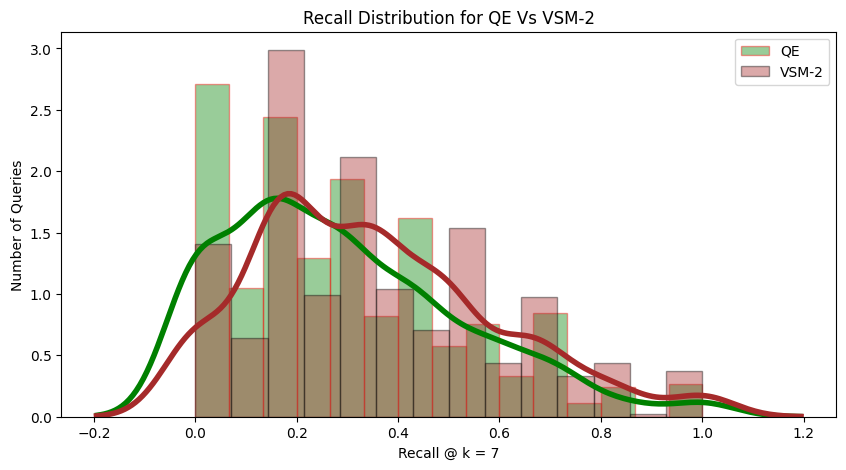

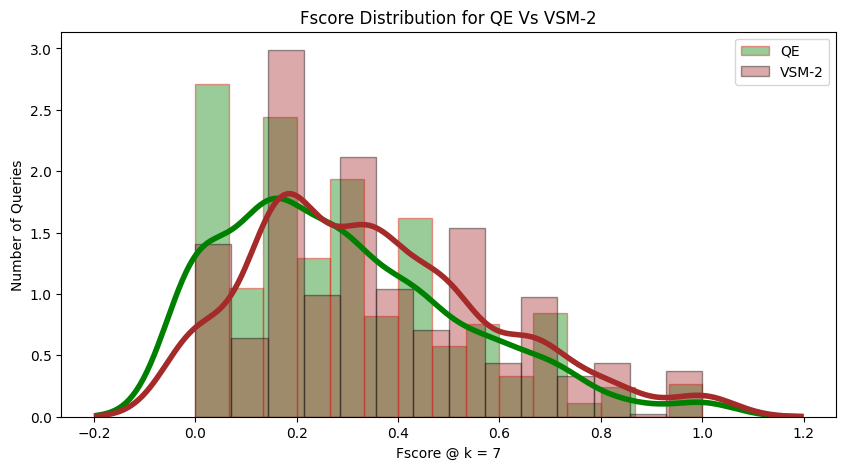

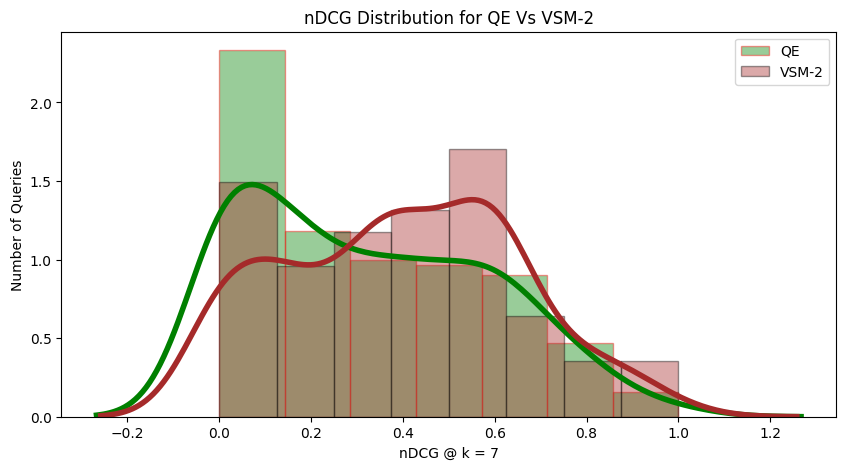

In [35]:
plot_pair(q_precision_qe, q_precision_vsm2, q_recall_qe, q_recall_vsm2,
         q_fscore_qe, q_fscore_vsm2, q_ndcg_qe, q_ndcg_vsm2, k = 7, model1_name = 'QE', model2_name = 'VSM-2')

### 7 Some  Examples of relevant and retrieved doc vs query

In [36]:
# example of Query 220
df = pd.DataFrame(qrels)
print("Expanded Query : ", query_df['expanded_query'][219])
print("Preprocessed Query : ", query_df['preprocessed'][219])
print("Words Added : ",query_df['expanded_query'][219].split(' ')[:5])
print("VSM Recall : ", q_recall_vsm2[219])
print("QE Recall : ", q_recall_qe[219])
print("Retrieved : ",doc_IDs_ordered_qe[219][:10])
print("Relevant : ", list(map(int, df[df['query_num'] == str(220)]['id'].tolist())))

Expanded Query :  dependence second iterative apply compressible layer layer boundary dimensional author agreement table excellent linearization capacityfind calculation procedure applicable incompressible laminar boundary layer flow problem good accuracy reasonable computation time
Preprocessed Query :  find calculation procedure applicable incompressible laminar boundary layer flow problem good accuracy reasonable computation time
Words Added :  ['dependence', 'second', 'iterative', 'apply', 'compressible']
VSM Recall :  0.0
QE Recall :  0.0
Retrieved :  [4, 376, 336, 3, 460, 1281, 1301, 16, 326, 671]
Relevant :  [1383, 1385, 155, 241, 1382, 1370, 1386, 111, 1384, 150, 292, 458, 479, 977, 376, 459, 1365, 62, 1366, 1182]


In [37]:
# example of Query 40
df = pd.DataFrame(qrels)
print("Expanded Query : ", query_df['expanded_query'][39])
print("Preprocessed Query : ", query_df['preprocessed'][39])
print("Words Added : ",query_df['expanded_query'][39].split(' ')[:5])
print("VSM Recall : ", q_recall_vsm2[39])
print("QE Recall : ", q_recall_qe[39])
print("Retrieved : ",doc_IDs_ordered_qe[39][:10])
print("Relevant : ", list(map(int, df[df['query_num'] == str(40)]['id'].tolist())))

Expanded Query :  domain contamination roughness gaseous nosed attachone detect transition phenomenon hypersonic wake
Preprocessed Query :  one detect transition phenomenon hypersonic wake
Words Added :  ['domain', 'contamination', 'roughness', 'gaseous', 'nosed']
VSM Recall :  0.16666666666666666
QE Recall :  0.14285714285714285
Retrieved :  [710, 43, 80, 96, 7, 8, 536, 314, 40, 1211]
Relevant :  [24, 283, 552, 272, 85, 976, 557, 558, 553, 554, 555, 556, 536]


## 5. KMeans Clustering


### 1 Fine Tuning for number of Clusters

For n_clusters = 2, silhouette score is 0.011620793140721467)
For n_clusters = 3, silhouette score is 0.012429277643912138)
For n_clusters = 4, silhouette score is 0.01423679883132838)
For n_clusters = 5, silhouette score is 0.016121949579479)
For n_clusters = 6, silhouette score is 0.016064942501891957)
For n_clusters = 7, silhouette score is 0.016907712183909622)
For n_clusters = 8, silhouette score is 0.018124320189214522)
For n_clusters = 9, silhouette score is 0.018577507603387576)
For n_clusters = 10, silhouette score is 0.019312001534319872)


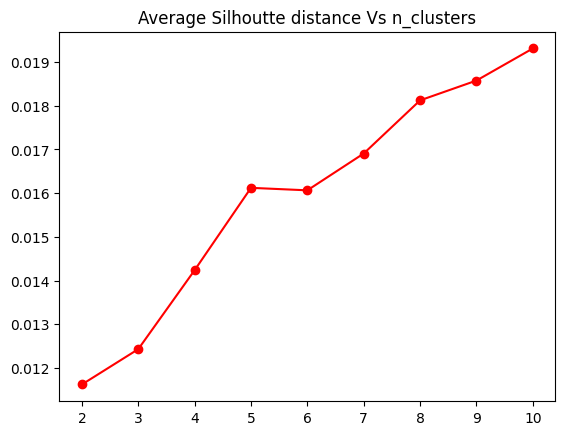

In [52]:
# tf-idf representation of documents
df_cluster = tf_idf_docs_lsa.T
# silhoutte scores to find the appropriate 
sil_scores = []
# tuning number of clusters using grid search, from 2 to 10
for n_clusters in range(2, 11):
    # Applying K-means
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_cluster)
    # finding cluster centers
    centers = clusterer.cluster_centers_

    score = silhouette_score(df_cluster, preds)
    sil_scores.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
plt.plot(list(range(2, 11)), sil_scores, marker='o', color='r')
plt.title("Average Silhoutte distance Vs n_clusters")
plt.show()


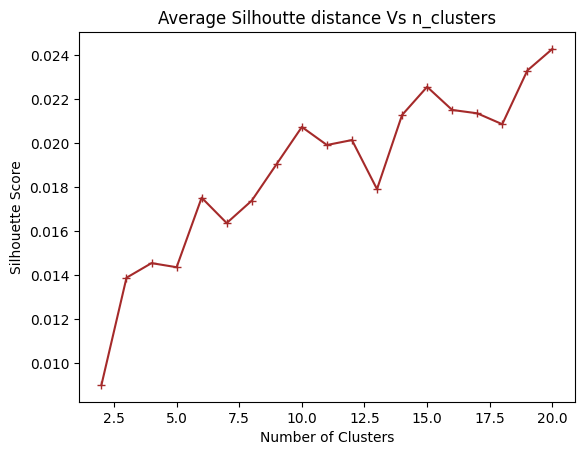

The best silhouette score is 0.024290059468357432 for n_clusters = 20


In [51]:
# Transpose TF-IDF matrix
df_cluster = tf_idf_docs_lsa.T

# Initialize variables to store silhouette scores and best score
best_score = -1
best_n_clusters = -1
sil_scores = []

# Iterate over different cluster counts
for n_clusters in range(2, 21):
    # Applying K-means
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_cluster)
    
    # Calculate silhouette score
    score = silhouette_score(df_cluster, preds)
    sil_scores.append(score)
    
    # Update best score and corresponding number of clusters
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

# Plotting silhouette scores
plt.plot(list(range(2, 21)), sil_scores, marker='+', color='brown')
plt.title("Average Silhoutte distance Vs n_clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Print the best silhouette score and corresponding number of clusters
print(f"The best silhouette score is {best_score} for n_clusters = {best_n_clusters}")


**Observation:**
Taking k = 12, clusters provided a reasonable trade-off between retrieval time and other assessment criteria. But choosing k = 20 resulted in a significant trade-off between retrieval time and other measures.




### 2 Distortion Calculations

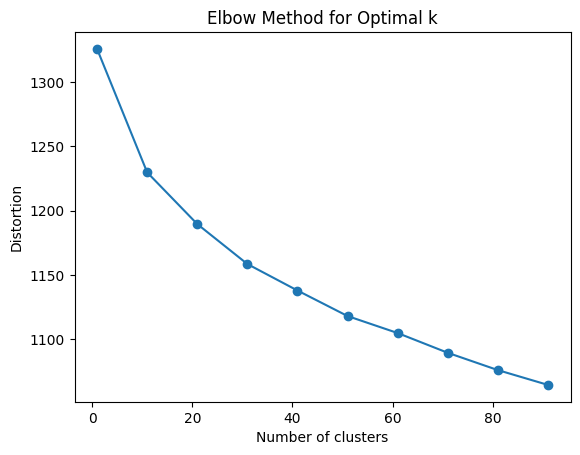

In [39]:
# Calculate distortion for a range of number of clusters
distortions = []

# Elbow plot to find the optimal clusters
for i in range(1, 100, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(tf_idf_docs_lsa.T)
    distortions.append(km.inertia_)

# Plot the distortion
plt.plot(list(range(1, 100, 10)), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

### 3 observation from the above curve, 
we may conclude that the best number of clusters is between 6 and 12. However, if we chose n = 12, the trade-off for accuracy, recall, and other metrics is enormous, and the retrieval times for n = 6 and n = 12 are fairly comparable. So we chose n = 12 as the best number of clusters.


In [40]:
# combining the query  and document.
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(f"{X.shape[0]} are total number of docs and queries and {X.shape[0]} is Vocabulary size ")

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tf_idf_docs_km= tfidf_df[columns[:len(docs_df)]].values # final representations of documents
vec_rep_queries_km= tfidf_df[columns[len(docs_df):]].values # final representations of queries

1625 are total number of docs and queries and 1625 is Vocabulary size 


In [41]:
# Best k = 12
km = KMeans(n_clusters= 12, random_state=0)
# fitting KMC on documents
km.fit(tf_idf_docs_km.T)
km.cluster_centers_.shape

(12, 5604)

In [42]:
cluster_doc_ids = {}
# assigning documents to various clusters
for i in range(1400):
    try :
        cluster_doc_ids[km.labels_[i]] += [i]
    except :
        cluster_doc_ids[km.labels_[i]] = [i]

### 4 Average Retrieval Time

In [43]:
# normal method of retrieval, finding the average retrieval time for a query.
tic = time.time()

for j in range(200): # iterating over queries
    cosine_sim_clust = []
    # iterating over all documents
    for i in range(1400):
        # cosine similarity
        cosine_sim_clust.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim_clust = np.array(cosine_sim_clust)
    doc_IDs_ordered_clust = (np.argsort(cosine_sim_clust,axis=0)+1)[::-1].T.tolist()
toc = time.time()
print("without clustering, Average Retrieval time : "+str((toc-tic)/200))

# clustering method
tic = time.time()
doc_IDs_ordered_kmeans = []
# iterating over queries
for j in range(200):
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clust = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered_kmeans.append(doc_IDs_ordered_clust)

toc = time.time()
print("clustering method, Retrieval time : "+str((toc-tic)/200))

without clustering, Average Retrieval time : 0.006166669130325317
clustering method, Retrieval time : 0.0015880048274993896


### 5 Observations and hypothesis testing

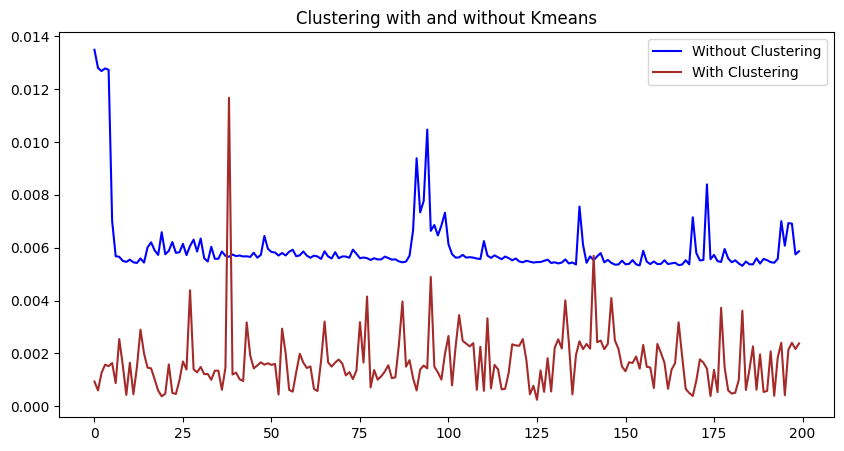

In [44]:
# we store the retrieval time taken for each query and store them as a list
without_clust = []
# iterating over 200 queries
for j in range(200):
    tic = time.time()
    cosine_sim = []
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    toc = time.time()
    without_clust.append((toc-tic))
    


with_clust = []
# clustering method
for j in range(200):
    tic = time.time()
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
    toc = time.time()
    with_clust.append((toc-tic))
    
# plot with and without kmeans clustering
plt.figure(figsize = (10,5))
plt.title('Clustering with and without Kmeans')
plt.plot(range(200), without_clust, label = 'Without Clustering',color='blue')
plt.plot(range(200), with_clust, label = 'With Clustering',color='brown')
plt.legend()
plt.show()

In [45]:
# hypothesis testing
hypothesis_test(without_clust, with_clust)

formula: t = 35.3276  p = 1.03177e-122


## 6 Topic Modelling using LDA

### 1 LDA

In [46]:
cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
dtm = cv.fit_transform(docs_df["preprocessed"])
# LDA
LDA = LatentDirichletAllocation(n_components=6, random_state = 42)
LDA.fit(dtm)
topic_results = LDA.transform(dtm)
docs_df["LDA_topics"] = topic_results.argmax(axis = 1)
docs_df.head()

,body,preprocessed,LDA_topics
0,experimental investigation of the aerodynamics...,experimental investigation aerodynamics wing s...,2
1,simple shear flow past a flat plate in an inco...,simple shear flow past flat plate incompressib...,5
2,the boundary layer in simple shear flow past a...,boundary layer simple shear flow past flat pla...,5
3,approximate solutions of the incompressible la...,approximate solution incompressible laminar bo...,5
4,one-dimensional transient heat conduction into...,one dimensional transient heat conduction doub...,0


### 2 Average Retrieval Time

In [47]:
# assigning documents to a topic
cluster_doc_ids = {}
for i in range(1400):
    try :
        cluster_doc_ids[docs_df["LDA_topics"][i]] += [i]
    except :
        cluster_doc_ids[docs_df["LDA_topics"][i]] = [i]
        
cluster_centres = np.zeros((6,5604))
for i in range(6):
    cluster_centres[i,:] = np.mean(tf_idf_docs_km[:,cluster_doc_ids[i]], axis = 1)
    
# normal method of retrieval
without_clust_lda = []
with_clust_lda = []
tic = time.time()
for j in range(200):
    cosine_sim = []
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
# print(len(doc_IDs_ordered))
toc = time.time()
print("without clustering, Retrieval time : "+str((toc-tic)/200))

# clustering method
tic = time.time()
for j in range(200):
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, cluster_centres.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
toc = time.time()
print("with clustering, Retrieval time : "+str((toc-tic)/200))

without clustering, Retrieval time : 0.006556258201599121
with clustering, Retrieval time : 0.003703625202178955


### 3 Results and Observations
As from above retrieval times, retrieval time for with lda is lesser than without lda retrieval time

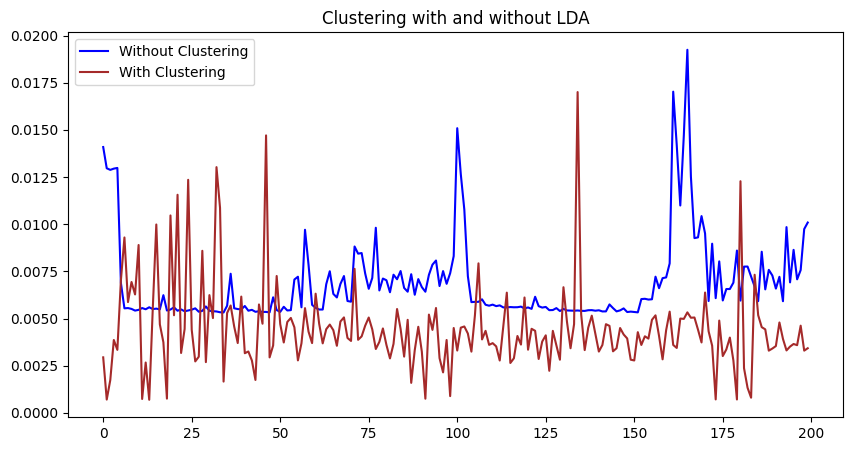

In [48]:
# we store the retrieval time taken for each query and store them as a list
without_clust_lda = [] 
with_clust_lda = []
# without cluster method
for j in range(200):
    cosine_sim = []
    tic = time.time()
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    toc = time.time()
    without_clust_lda.append((toc-tic))

# with clustering method
for j in range(200):
    tic = time.time()
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, cluster_centres.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
#     doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
    toc = time.time()
    with_clust_lda.append((toc-tic))

# plot with and without cluster using LDA
plt.figure(figsize = (10,5))
plt.title('Clustering with and without LDA')
plt.plot(range(200), without_clust_lda, label = 'Without Clustering',color='blue')
plt.plot(range(200), with_clust_lda, label = 'With Clustering',color='brown')
plt.legend()
plt.show()